In [182]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os
from scipy import ndimage

In [183]:
def getScan(scanPath):
    
    data = sitk.ReadImage(scanPath)
    scan = sitk.GetArrayFromImage(data)
    
    return scan

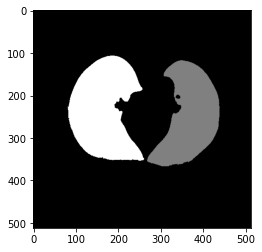

In [206]:
scan = getScan("/Users/phoenixji/Desktop/LungData/Covid-DirectSeg-Data/Zenodo Data/Lung_Mask/coronacases_002.nii.gz")
plt.imshow(scan[130],cmap='gray')

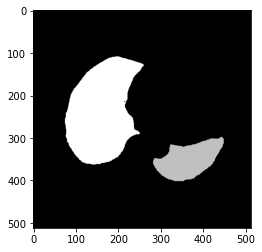

In [180]:
scan = getScan("/Users/phoenixji/Desktop/LungData/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd")
plt.imshow(scan[55],cmap='gray')

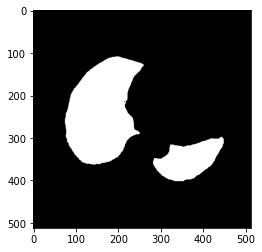

In [181]:
scan = np.where(scan==0,scan,1)
plt.imshow(scan[55],cmap='gray')

In [5]:
def normalizeScan(volume):
    
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume-min)/(max-min)
    volume = volume.astype("float32")
    
    return volume

In [6]:
def resizeScan(scan,target_shape):
        
    current_width,current_height,current_depth = scan.shape
        
    target_width,target_height,target_depth = target_shape
    
    # Compute depth factor by 1/(D/N) 
    # Refer to the paper Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction
    
    width_factor = 1/(current_width/target_width)
    height_factor = 1/(current_height/target_height)
    depth_factor = 1/(current_depth/target_depth)
    
    # ndimage.zoom(): The array is zoomed using spline interpolation of the requested order.
    #scan = ndimage.rotate(scan, 90, reshape=False)
    
    scan = ndimage.zoom(scan,(width_factor,height_factor,depth_factor),order = 1)
    
    #print(width_factor,height_factor,depth_factor)
    
    return scan

In [7]:
def preprocessScan(scanPath,target_shape):
    
    scan = getScan(scanPath)
    
    if(scan.shape[0] != scan.shape[1]):
        scan = np.swapaxes(scan,0,1)  #(64,128,128) => (128,128,64)
        scan = np.swapaxes(scan,1,2)
        
    scan = normalizeScan(scan)
    
    scan = resizeScan(scan,target_shape)
    
  
    
    return scan

In [8]:
def getLungSegScan(ScanPath):

    scan = getScan(ScanPath)
    lungMask = np.array([get_segmented_lungs(slice.copy()) for slice in scan])
    scan[~lungMask] = 0
    scan = normalizeScan(scan)


    if(scan.shape[0] != scan.shape[1]):
      scan = np.swapaxes(scan,0,1)  
      scan = np.swapaxes(scan,1,2)

    scan = resizeScan(scan,(128,128,64))
    scan = np.expand_dims(scan,axis=-1)

    return scan